What we need is a small parcel to work on, with a nice contourplot with critical points and minima found after initiating local method and then a 3d plot. 

In [21]:
using Globtim
include("../src/lib_func.jl")

# Constants and Parameters
d = 8 # Initial Degree 
const n, a, b = 2, 5, 1 
const scale_factor = a / b       # Scaling factor appears in `main_computation`, maybe it should be a parameter.
const delta, alpha = .9 , 8 / 10  # Sampling parameters
const tol_l2 = 3e-4             # Define the tolerance for the L2-norm

f = camel # Objective function

camel (generic function with 1 method)

We need to also return the number of samples used to generate the sample set. It is annoying that the error goes up while the degree has increased.

In [22]:
while true # Potential infinite loop
    global poly_approx = MainGenerate(f, 2, d, delta, alpha, scale_factor, 0.2) # computes the approximant in Chebyshev basis
    if poly_approx.nrm < tol_l2
        println("attained the desired L2-norm: ", poly_approx.nrm)
        break
    else
        println("current L2-norm: ", poly_approx.nrm)
        println("Number of samples: ", poly_approx.N)
        global d += 1
    end
end

attained the desired L2-norm: 1.88995736054401e-13


We define the file names

In [23]:
# Assuming x is already defined as @polyvar x[1:2]
loc = "inputs.ms"
# File path of the output file
file_path_output = "outputs.ms";

We now expand the approximant computed in the tensorized Chebyshev basis into standard monomial basis.

In [30]:
using DynamicPolynomials, DataFrames
ap = main_nd(n, d, poly_approx.coeffs) 
@polyvar(x[1:n]) # Define polynomial ring 
# Expand the polynomial approximant to the standard monomial basis in the Lexicographic order w.r.t x
names = [x[i].name for i in 1:length(x)]
open(loc, "w") do file
    println(file, join(names, ", "))
    println(file, 0)
end
# Define the polynomial approximant 
PolynomialApproximant = sum(ap .* MonomialVector(x, 0:d))
for i in 1:n
    partial = differentiate(PolynomialApproximant, x[i])
    partial_str = replace(string(partial), "//" => "/")
    open(loc, "a") do file
        if i < n
            println(file, string(partial_str, ","))
        else
            println(file, partial_str)
        end
    end
end

Solve the system of partial derivatives using HomotopyContinuation. Note that without the conversion to floating point coefficients, there is an issue if we try to use BigFloats directly. 

In [31]:
run(`msolve -v 1 -f inputs.ms -o outputs.ms`)


--------------- INPUT DATA ---------------
#variables                       2
#equations                       2
#invalid equations               0
field characteristic             0
homogeneous input?               0
signature-based computation      0
monomial order                 DRL
basis hash table resetting     OFF
linear algebra option            2
initial hash table size     131072 (2^17)
max pair selection             ALL
reduce gb                        1
#threads                         1
info level                       1
generate pbm files               0
------------------------------------------
Dimension of quotient: 49
[49, 7], Non trivial / Trivial = 14.29%
Density of non-trivial part 89.80%
Time spent to generate sequence (elapsed): 0.00 sec (0.02 Gops/sec)
Time spent to compute eliminating polynomial (elapsed): 0.00 sec
Elimination polynomial has degree 49.

Starts multi-modular computations
{2}{4}{8}{16}{32}
<Step:2/0.00/0.00>{64}


---------------- TIMINGS ---------------
overall(elapsed)        0.00 sec
overall(cpu)            0.00 sec
select                  0.00 sec   7.3%
symbolic prep.          0.00 sec   9.4%
update                  0.00 sec  22.2%
convert                 0.00 sec  26.0%
linear algebra          0.00 sec  10.7%
reduce gb               0.00 sec   0.0%
-----------------------------------------

---------- COMPUTATIONAL DATA -----------
size of basis                     8
#terms in basis                 350
#pairs reduced                    8
#GM criterion                    28
#redundant elements               1
#rows reduced                    24
#zero reductions                  1
max. matrix data                 17 x 65 (69.321%)
max. symbolic hash table size  2^11
max. basis hash table size     2^16
-----------------------------------------



[0][1]
84 primes used
Time for CRT + rational reconstruction = 0.02
Time for rational param:          0.31 (elapsed) sec /  0.31 sec (cpu)

Real root isolation starts at precision 173
Number of real roots: 15
Starts real root extraction.
Elapsed time (real root extraction) = 0.00
------------------------------------------------------------------------------------
msolve overall time           0.32 sec (elapsed) /  0.32 sec (cpu)
------------------------------------------------------------------------------------


Process(`msolve -v 1 -f inputs.ms -o outputs.ms`, ProcessExited(0))

In [32]:
function average(X::Vector{Int})::Float64
    return sum(X) / length(X)
end

# Process the file and get the points
evaled = process_output_file(file_path_output)

# Parse the points into correct format
real_pts = []
for pts in evaled
    if typeof(pts)== Vector{Vector{Vector{BigInt}}}
        X = parse_point(pts)
    else 
        X = average.(pts) 
    end
    push!(real_pts, Float64.(X))
end

[0, [1,
[[[57970732527237481272508810679209324317 / 2^127, 115941465054474962545017621358418648635 / 2^128], [-2046811156655134529191235366905940742425436246420811781552385 / 2^203, -7995356080684119254653263151976331025099360337581296021689 / 2^195]], [[37744301740929439845621005057989156407 / 2^127, 75488603481858879691242010115978312815 / 2^128], [-1928998790693485573866453073024134391687152243883315129085 / 2^193, -30863980651095769181863249168386150266994435902133042065359 / 2^197]], [[6114330573343049503029723766438422467 / 2^128, 1528582643335762375757430941609605617 / 2^126], [-1832311498398014903687991381390513076147630957218897009693531 / 2^203, -916155749199007451843995690695256538073815478609448504846765 / 2^202]], [[-44102985820751416128395266003820162427 / 2^127, -88205971641502832256790532007640324853 / 2^128], [-398267647232597093449295916093460715074687928752124814820332349 / 2^211, -1593070588930388373797183664373842860298751715008499259281329395 / 2^213]], [[-6835867

Sort through the critical points, make sure they fall into the domain of definition. Make them into a Dataframe.

In [33]:
condition(point) = -1 < point[1] < 1 && -1 < point[2] < 1
filtered_points = filter(condition, real_pts) # Filter points using the filter function
# Colllect the critical points of the approximant 
h_x = Float64[point[1] for point in filtered_points] # Initialize the x vector for critical points of approximant
h_y = Float64[point[2] for point in filtered_points] # Initialize the y vector
h_z = map(p -> f([p[1], p[2]]), zip(scale_factor * h_x, scale_factor * h_y))
df = DataFrame(x=scale_factor * h_x, y=scale_factor * h_y, z= h_z) # Create a DataFrame

Row,x,y,z
,Float64,Float64,Float64
1,1.70361,-0.796084,-0.215464
2,1.10921,-0.768268,0.543719
3,0.089842,-0.712656,-1.03163
4,-1.29607,-0.605084,2.22947
5,-1.6071,-0.568651,2.10425
6,-1.63807,-0.228674,2.22936
7,-1.23023,-0.162335,2.4963
8,-2.45544e-14,1.6958e-13,-1.16781e-25
9,1.23023,0.162335,2.4963


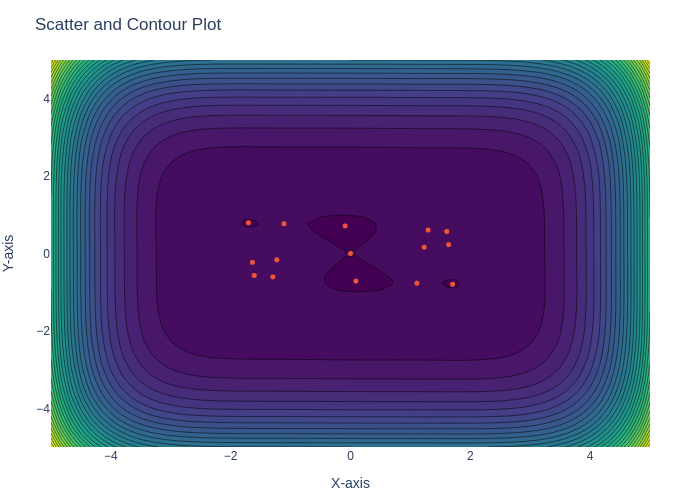

In [34]:
using PlotlyJS, Colors
# Generate the grid and evaluate the function
N = 60  # resolution of the grid
x = range(-scale_factor, scale_factor, length=N)
y = range(-scale_factor, scale_factor, length=N)
z = [f([xi, yi]) for yi in y, xi in x]

#Scatter plot the critical points of the approximant
scatter_traces = [scatter(x=df.x, y=df.y, mode="markers", marker_size=5, name="Critical Points")]

# Create the contour plot
cp = contour(x=x, y=y, z=z, ncontours=40, colorscale="Viridis", showscale=false)

# Combine contour plot and scatter traces
all_traces = [cp; scatter_traces...]

# Customize layout to handle legend groups
layout = Layout(
    title="Scatter and Contour Plot",
    xaxis_title="X-axis",
    yaxis_title="Y-axis",
    legend=(tracegroupgap=10, groupclick="toggleitem"),
    height=800 # Increase the height to make room for the legend 
)

# Display the combined plot with legend
display(plot(all_traces, layout))



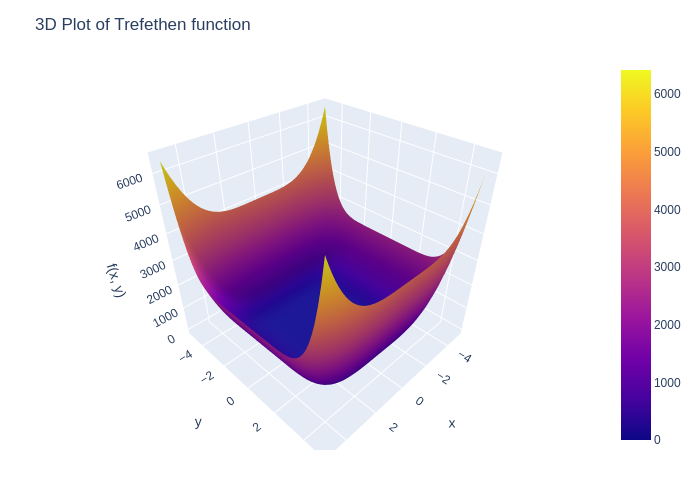

In [29]:
sf = surface(x=x, y=y, z=z)
# Had to switch the coordinates of the critical points to match the surface plot for some reason. 
crit_pts = scatter3d(x=df.y, y=df.x, z=df.z, mode="markers", marker_size=5, name="Critical Points")

# Layout for the plot
layout = Layout(title="3D Plot of Trefethen function",
    scene=attr(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="f(x, y)"),
        height=800
)
# Display the plot layout,
plot([sf,  crit_pts], layout)